POINGT Camille  
HOANG Phi-hung

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import tensorflow as tf
import glob
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# classification d'image de navires par réseau de neurones
Pour ce projet, nous avons eu pour objectif de créer un CNN à la main en moins de 30 couches.  
Par ce biais, il nous a été fournit un dossier comprenant plusieurs images de navire de différents types qu'on utilisera pour entraîner le réseau.  
On essaiera donc d'améliorer au mieux sa précision afin qu'il puisse par lui même discerner quel genre de navire on lui a donné en entrée.  
Par ailleurs la precision du réseaux de neurone est classé parmis les autres, donc plus précis il est, mieux classé le réseau de neurone sera.

## Récupération des images et transformation des données en dataset  
Puisque les données sont des images chacun classé dans un dossier par leur type, nous avons décidé d'utiliser la fonction tf.keras.utils.image_dataset_from_directory() qui permet de classer de manière automatique les données dans les datasets.  
Comme vous pouvez les voir nous avons décidé de faire deux jeux de données: un pour l'entrainement et l'autre pour la validation.

En apprentissage automatique, une tâche courante est l'étude et la construction d' algorithmes qui peuvent apprendre et faire des prédictions sur les données.  
De tels algorithmes fonctionnent en faisant des prédictions ou des décisions basées sur les données, en construisant un modèle mathématique à partir des données d'entrée. Ces données d'entrée utilisées pour construire le modèle sont généralement divisées en plusieurs jeux de données.  
En particulier, trois jeux de données sont couramment utilisés à différentes étapes de la création du modèle : les jeux d'apprentissage, de validation et de test. Le modèle est initialement ajusté sur un jeu de données d'apprentissage qui est un jeu d'exemples utilisés pour ajuster les paramètres (par exemple, les poids des connexions entre les neurones dans les réseaux de neurones artificiels) du modèle. Le modèle est entraîné sur le jeu de données d'apprentissage à l'aide d'une méthode d'apprentissage supervisé, par exemple à l'aide de méthodes d'optimisation telles que la descente de gradient ou la descente de gradient stochastique. Le modèle ajusté est ensuite utilisé pour prédire les réponses pour les observations dans un deuxième jeu de données appelé jeu de données de validation.   
Le jeu de données de validation fournit une évaluation impartiale d'un ajustement de modèle sur le jeu de données d'apprentissage tout en ajustant les hyperparamètres (par exemple, le nombre d'unités cachées - couches et largeurs de couche - dans un réseau de neurones). Les jeux de données de validation peuvent être utilisés pour la régularisation par arrêt anticipé (arrêt de l'entraînement lorsque l'erreur sur le jeu de données de validation augmente, car cela est un signe de sur-apprentissage du jeu de données d'entraînement).

En résumé, le but du jeu de validation est donc d'évaluer la qualité du modèle appris sur le jeu d'apprentissage et ainsi éviter le sur-apprentissage. 

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data/', label_mode="categorical",
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(16, 24))

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data/', label_mode="categorical",
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(16, 24))

Found 35515 files belonging to 10 classes.
Using 31964 files for training.
Found 35515 files belonging to 10 classes.
Using 3551 files for validation.


## création du modèle de réseau de neurone
Dans ce model de réseau de neurone, voici les couches qui on été utilisé:

- La première couche est une couche de redimensionnement qui redimensionne l'image d'entrée en 48x48 pixels.
- Les couches Conv2D sont des couches de convolution qui appliquent un filtre à l'image pour extraire des fonctionnalités importantes telles que les bords, les coins et les formes.
- Les couches BatchNormalization sont des couches de normalisation qui normalisent les activations de chaque couche pour éviter le surapprentissage et accélérer l'apprentissage.
- Les couches MaxPooling2D sont des couches de sous-échantillonnage qui réduisent la dimensionnalité des cartes de fonctionnalités en prenant la valeur maximale dans chaque région de la carte de fonctionnalités.
- Les couches Dropout sont des couches de régularisation qui désactivent aléatoirement certains neurones pendant l'entraînement pour éviter le surapprentissage.

Quant aux couches Dense, elles sont utilisées pour réduire la dimensionnalité des cartes de fonctionnalités en appliquant une transformation linéaire à l’entrée et en appliquant ensuite une fonction d’activation non linéaire. Elles vont permettre à la fin que le réseau de neurone puisse bien classifier l'image en entrée.

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Rescaling
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import regularizers
from keras import layers
from keras.layers import Resizing
from keras.optimizers import Adadelta,Adam
from keras.layers import LeakyReLU

strategy = tf.distribute.MirroredStrategy()

def build_model():

    model = Sequential()

    model.add(Resizing(48,48,input_shape = (16,24,3)))
    
    model.add(Conv2D(128, [3, 3], activation=LeakyReLU(alpha=0.1), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, [3, 3], activation=LeakyReLU(alpha=0.1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, [3, 3], activation=LeakyReLU(alpha=0.1), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, [3, 3], activation=LeakyReLU(alpha=0.1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(512, [3, 3],  activation=LeakyReLU(alpha=0.1), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, [3, 3],  activation=LeakyReLU(alpha=0.1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))
    

    model.add(Conv2D(1024, [3, 3],  activation=LeakyReLU(alpha=0.1), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(1024, [3, 3],  activation=LeakyReLU(alpha=0.1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())    
    model.add(Dense(512,  activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.60)))
    model.add(Dense(256,  activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.60)))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(learning_rate=0.0178),      
                  metrics=['accuracy'])
    return model

# buiding a model inside the strategy scope
#with strategy.scope():
multi_gpu_model = build_model()
    
multi_gpu_model.summary()
print(len(multi_gpu_model.layers))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 128)      0

## Entraînement du réseau de neurone

In [5]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True,)
model_history = multi_gpu_model.fit(train_ds, validation_data = val_ds, epochs=60, batch_size = 258, callbacks = [early_stopping])

Epoch 1/60


2023-05-27 22:20:54.066574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


999/999 [==============================] - 64s 57ms/step - loss: 325.5825 - accuracy: 0.2794 - val_loss: 82.9650 - val_accuracy: 0.2320
Epoch 2/60
999/999 [==============================] - 50s 50ms/step - loss: 34.4716 - accuracy: 0.4189 - val_loss: 9.9991 - val_accuracy: 0.4165
Epoch 3/60
999/999 [==============================] - 49s 49ms/step - loss: 4.5670 - accuracy: 0.4834 - val_loss: 2.3532 - val_accuracy: 0.4542
Epoch 4/60
999/999 [==============================] - 50s 50ms/step - loss: 1.9148 - accuracy: 0.5178 - val_loss: 1.7870 - val_accuracy: 0.4855
Epoch 5/60
999/999 [==============================] - 49s 49ms/step - loss: 1.6527 - accuracy: 0.5374 - val_loss: 1.5886 - val_accuracy: 0.5339
Epoch 6/60
999/999 [==============================] - 49s 49ms/step - loss: 1.5646 - accuracy: 0.5540 - val_loss: 1.5666 - val_accuracy: 0.5469
Epoch 7/60
999/999 [==============================] - 50s 49ms/step - loss: 1.5072 - accuracy: 0.5666 - val_loss: 1.4960 - val_accuracy: 0.5573

## Précision du réseau de neurone

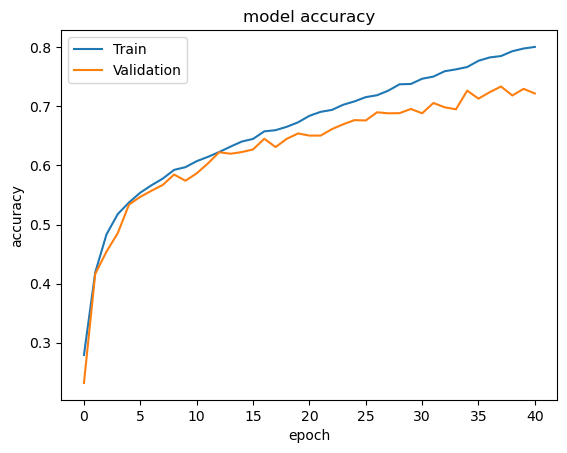

In [6]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Avec les résultats donnés, on peut observer que même si l'accuracy évolue à peu près pour le mieux à chaque époque, la différence entre celle de l'entrainement et celle de la validation est assez importante. On peut alors parler d'overfit  
Cela pourrait s'expliquer par plusieurs facteurs: 
- le fait que les hyperparamètres ne soient pas les plus optimaux
- le fait que les dropouts et que la regularisation l2 ne soient pas assez important pour une homogenéisation des précisions
- le fait que les données ne soient pas assez nombreuses pour l'entraînement
- le fait que le nombre de paramètre en entrée soit trop important

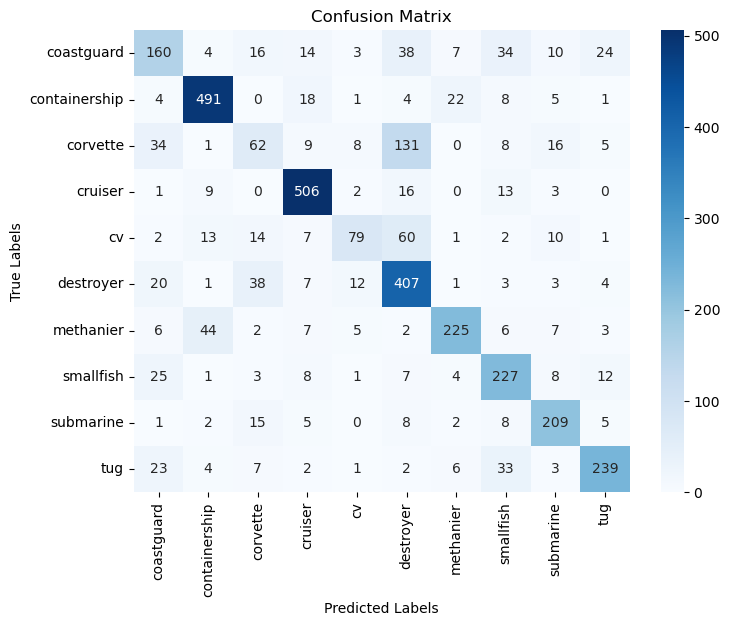

In [8]:
import seaborn as sns
import tensorflow as tf
y_true = []
y_pred = []
for x,y in val_ds:
    x_predict = multi_gpu_model.predict(x,verbose=0)
    y = tf.argmax(y,axis=1)
    y_true.append(y)
    y_pred.append(tf.argmax(x_predict ,axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

classes = ['coastguard', 'containership', 'corvette', 'cruiser', 'cv', 'destroyer', 'methanier', 'smallfish', 'submarine', 'tug']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Concernant la matrice de confusion, nous pouvons en conclure que le réseau de neurone renvoie de bons résultats puisque presque la totalité des prédictions concordent avec les vraies résultats

## Resultat a soumettre

In [9]:
X_test = np.load('/kaggle/input/navires-2023-la-mano/test.npy', allow_pickle=True)
X_test = X_test.astype('float32')

In [10]:
res = multi_gpu_model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

116/116 [==============================] - 2s 14ms/step


In [11]:
!head submission.csv

Id,Category
0,5
1,8
2,2
3,1
4,3
5,0
6,3
7,3
8,5


In [12]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [13]:
!rm -rf ships32/